In [11]:
from matplotlib import pyplot as plt
import numpy as np
import json
import os

folders = ['Bayesian','GA', 'GWO', 'PSO', 'SAC', 'TD3']
exp_1 = "20250808_164928_std_wayp_no_initobs_no_wind_large_bounds"
exp_2 = "20250820_115225_std_wayp_yes_initobs_no_wind_small_bounds"
exp_3 = "20250821_084443_std_wayp_yes_initobs_yes_wind_small_bounds"
exp_list = [exp_1, exp_2, exp_3]


In [12]:
def _parse_targets(stream):
    """Read line-delimited JSON and return sorted numpy arrays (times, targets)."""
    times, targets = [], []
    for line in stream:
        s = line.strip()
        if not s:
            continue
        try:
            obj = json.loads(s)
        except json.JSONDecodeError:
            continue
        target = obj.get("target", None)
        dt = obj.get("datetime", None)
        if target is None or dt is None:
            continue
        try:
            elapsed = float(dt.get("elapsed", 0.0))
            target = float(target)
        except (TypeError, ValueError):
            continue
        times.append(elapsed)
        targets.append(abs(target))

    if not times:
        return {"times": np.array([], dtype=float), "targets": np.array([], dtype=float)}

    # sort by time in case the log has out-of-order entries
    times = np.array(times, dtype=float)
    targets = np.array(targets, dtype=float)
    order = np.argsort(times)
    return {"times": times[order], "targets": targets[order]}

In [13]:
# Load all logs
all_targets = {}
for folder in folders:
    all_targets[folder] = {}
    for exp_name in exp_list:
        log_path = os.path.join(folder, exp_name, "optimization_log.json")
        if not os.path.isfile(log_path):
            print(f"Missing file: {log_path}")
            all_targets[folder][exp_name] = {"times": np.array([], float), "targets": np.array([], float)}
            continue
        with open(log_path, "r") as f:
            all_targets[folder][exp_name] = _parse_targets(f)

In [14]:
def cumulative_min_by_time(times: np.ndarray, vals: np.ndarray, bin_seconds: float):
    """
    Compute cumulative absolute min of `vals` evaluated at the end of each time bin.
    Returns (bin_edges_without_zero, cum_min_values).
    """
    if times.size == 0:
        return np.array([], dtype=float), np.array([], dtype=float)

    t_end = times[-1]
    # Guard against zero or tiny bin size
    bin_seconds = max(float(bin_seconds), 1e-9)
    # Bin edges from 0 to t_end, include the last edge
    edges = np.arange(0.0, t_end + bin_seconds, bin_seconds)
    if edges.size < 2:
        edges = np.array([0.0, t_end], dtype=float)

    cum_mins = []
    for edge in edges[1:]:
        mask = times <= edge
        if not np.any(mask):
            cum_mins.append(np.nan)  # nothing yet in this bin
        else:
            cum_mins.append(float(np.min(np.abs(vals[mask]))))

    return edges[1:], np.array(cum_mins, dtype=float)

In [15]:
def group(data: np.ndarray, n: int) -> np.ndarray:
    """Group data into chunks of size n getting the increasing absolute minimum for each chunk."""
    new_data = []
    for i in range(0, len(data), n):
        new_data.append(np.min(np.abs(data[0:i+n])))
    return np.array(new_data)    

In [32]:
SEC_PER_HOUR = 3600.0

def plot_alg_performance(title, exp, group_size=20.0, xlim=None, ylim=None, n_markers=25, markersize=5, manual_tuning_value=None, legend_loc='upper right'):
    """
    Plot cost vs time (in hours):
      - Left: cumulative best (absolute) cost over elapsed time, evaluated on time bins of `group_size` seconds.
      - Right: best absolute cost achieved per algorithm (bar chart), computed ONLY from points within the visible x-range.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={"width_ratios": [2, 1]})

    # ---------- Left plot: grouped targets over elapsed time ----------
    linestyles = ['-', '--', '-.', ':']
    markers = ['x', 'o', '^']
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink']
    color_map = {alg: colors[i % len(colors)] for i, alg in enumerate(folders)}

    any_series = False
    global_tmax_sec = 0.0  # in seconds
    series_cache = {}

    for algorithm in folders:
        data = all_targets.get(algorithm, {}).get(exp, {"times": np.array([], float), "targets": np.array([], float)})
        times_sec = data["times"]
        targets = data["targets"]
        if times_sec.size == 0:
            continue

        series_cache[algorithm] = (times_sec, targets)
        any_series = True
        global_tmax_sec = max(global_tmax_sec, float(times_sec[-1]))

        # cumulative abs-min per time bin (seconds)
        x_time_sec, y_best = cumulative_min_by_time(times_sec, targets, bin_seconds=group_size)
        x_time_hr = x_time_sec / SEC_PER_HOUR  # convert to hours

        # markevery: number of markers evenly across n_markers points
        if len(x_time_hr) > 0:
            step = max(1, len(x_time_hr) // n_markers)
            markevery = np.arange(0, len(x_time_hr), step)
        else:
            markevery = None

        axs[0].plot(
            x_time_hr,
            y_best,
            label=f"{algorithm}",
            linestyle=linestyles[folders.index(algorithm) % len(linestyles)],
            marker=markers[folders.index(algorithm) % len(markers)],
            markevery=markevery,
            markersize=markersize,  # reduced marker size
            color=color_map[algorithm]
        )

    axs[0].set_title(title)
    axs[0].set_xlabel("Elapsed time [h]")
    axs[0].set_ylabel("Cost value")
    axs[0].grid(True)

    # Determine visible window (seconds), then set xlim in hours
    if any_series:
        if xlim is None:
            visible_sec = (0.0, global_tmax_sec)
            axs[0].set_xlim(0.0, global_tmax_sec / SEC_PER_HOUR)
        else:
            visible_sec = (float(xlim[0]), float(xlim[1]))
            axs[0].set_xlim(visible_sec[0] / SEC_PER_HOUR, visible_sec[1] / SEC_PER_HOUR)
        if ylim is not None:
            axs[0].set_ylim(ylim)
    axs[0].legend(loc=legend_loc)

    # ---------- Right plot: min cost per algorithm within visible x range ----------
    min_costs = []
    if any_series:
        v0, v1 = visible_sec
        for algorithm in folders:
            if algorithm not in series_cache:
                continue
            times_sec, targets = series_cache[algorithm]
            mask = (times_sec >= v0) & (times_sec <= v1)
            if not np.any(mask):
                continue
            min_val = float(np.min(np.abs(targets[mask])))
            min_costs.append((algorithm, min_val))

    if min_costs:
        min_costs_sorted = sorted(min_costs, key=lambda kv: kv[1], reverse=True)
        names = [kv[0] for kv in min_costs_sorted]
        values = [kv[1] for kv in min_costs_sorted]

        if manual_tuning_value is not None:
            names.insert(0,"Manual Tuning")
            values.insert(0, manual_tuning_value)
            color_map["Manual Tuning"] = "tab:gray"

        x = np.arange(len(names))
        bars = axs[1].bar(x, values, color=[color_map[name] for name in names])
        axs[1].set_xticks(x)
        axs[1].set_xticklabels(names, rotation=30, ha="right")
        axs[1].set_ylabel("Cost")
        axs[1].set_title("Best Costs (lower is better)")
        for rect, val in zip(bars, values):
            axs[1].text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), f"{val:.1f}",
                        ha="center", va="bottom")
    else:
        axs[1].text(0.5, 0.5, "No data to summarize\n(in visible time window)",
                    ha="center", va="center", transform=axs[1].transAxes)
        axs[1].set_axis_off()

    plt.tight_layout()
    plt.savefig(f"{exp}_hours.png", dpi=300)
    plt.show()


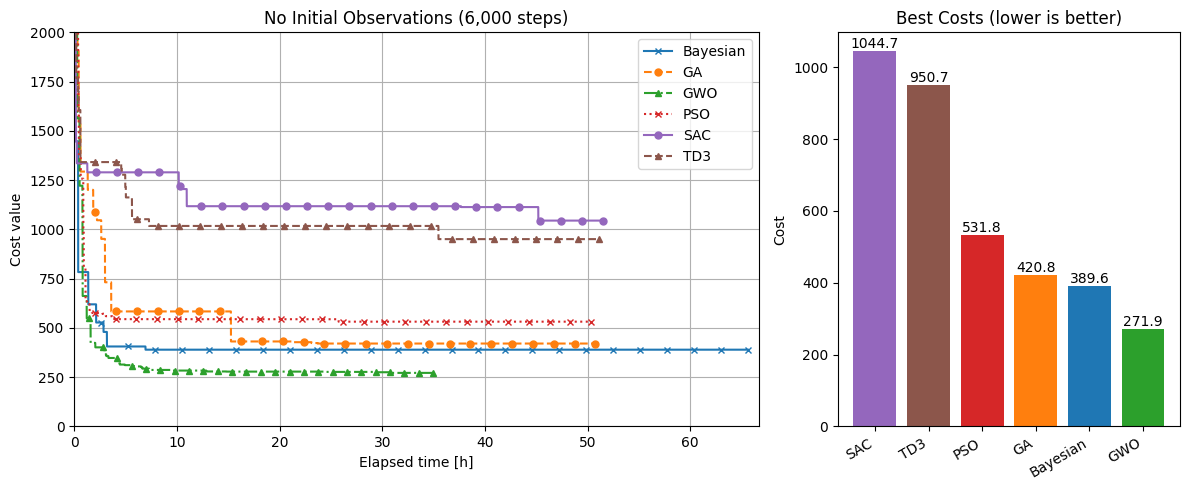

In [33]:
plot_alg_performance("No Initial Observations (6,000 steps)", exp_1, xlim=(0, 240000), ylim=(0, 2000), group_size=10.0)


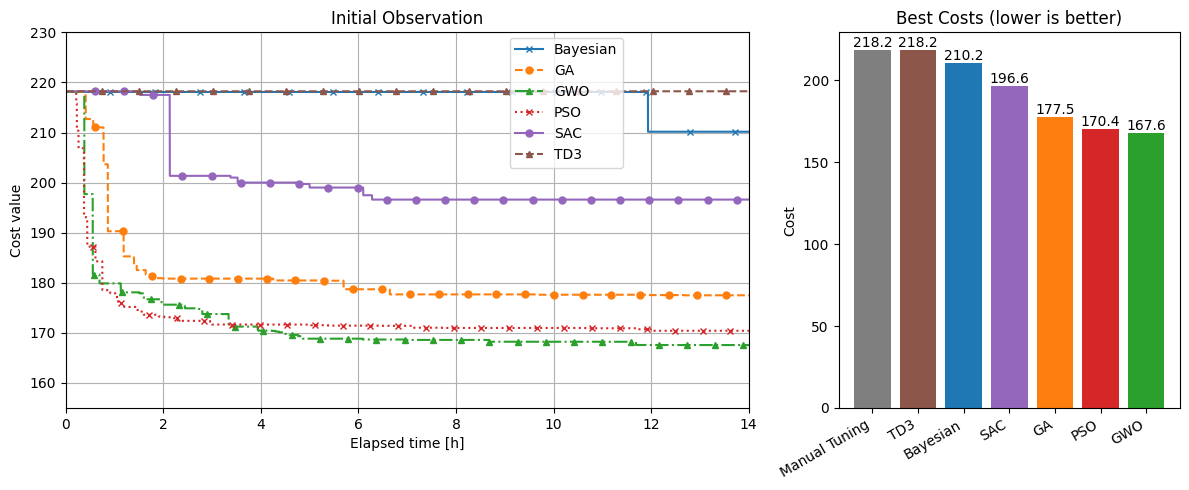

In [49]:
plot_alg_performance("Initial Observation", exp_2, xlim=(0, 50400), ylim=(155, 230), group_size=1.0, manual_tuning_value=218.2, legend_loc=(0.65,0.64))

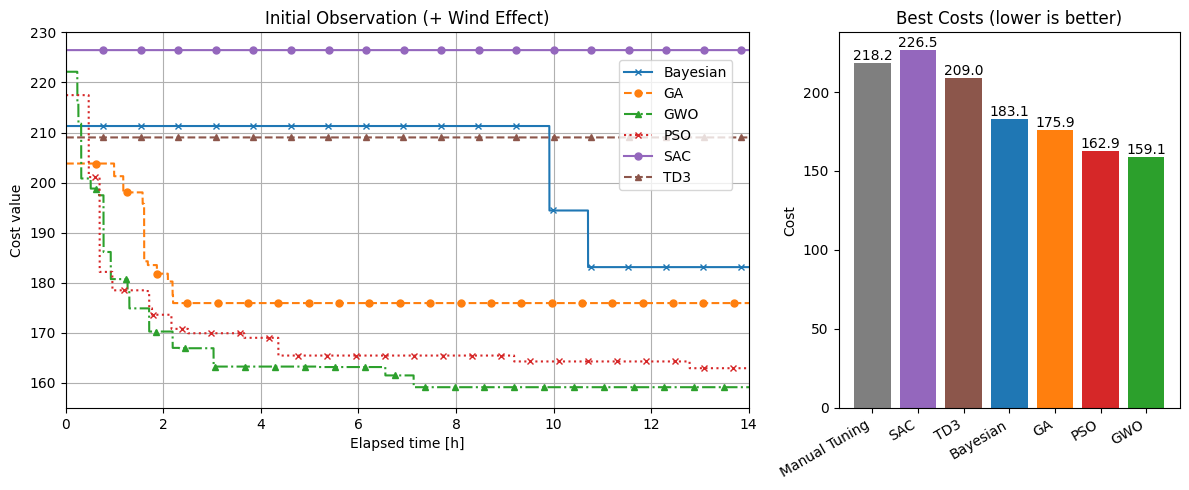

In [52]:
plot_alg_performance("Initial Observation (+ Wind Effect)", exp_3, xlim=(0, 50400), ylim=(155, 230), group_size=1.0, manual_tuning_value=218.2, legend_loc=(0.81,0.58))